In [191]:
import graph_tool as gt
from graph_tool.draw import graph_draw
import graph_tool.collection
import graph_tool.generation as gen
import axelrod as axl
import pandas as pd
import toolz as tz
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice, sample
from copy import deepcopy
from collections import Counter
from itertools import product
from time import time
%matplotlib inline


In [25]:
# project params
outputPath = './sf.png'


In [26]:
# network params
N = _N = 1000
_m = 2
_c = 0 
_gamma = 1

# game params
_R=1
_P=0
_T=1.5 # T€[0,2] 
_S=-.5 # S€[-1,1]

# evo params
_episode_n = 100
_te = 1
_ta = 0.5
_W = _te/_ta
_beta = 0.05

In [124]:
'''Utils'''
def transposeList(l) = list(map(list, zip(*l)))

In [27]:
'''Init''' 
C = 'C'
D = 'D'
def initStrats(N) = [choice([C,D]) for i in range(N)]
def initPayoffs(N) = [0 for i in range(N)]

'''Graph'''
def initGraph(N=_N, m=_m, c=_c, gamma=_gamma) = gen.price_network(N=N, m=m, c=c, gamma=gamma, directed=False)
def getNeighborIds(graph, id) = graph.vertex(id).out_neighbors() |> map$(int) |> list
def sampleNeighbor(graph, id) = choice(getNeighborIds(graph, id))
def sampleNeighborUnique(graph, id1, id2) = set(getNeighborIds(graph, id1)) - set(getNeighborIds(graph, id2)) - set([id2]) |> list |> choice
def isLonely(graph, x) = len(graph.get_all_edges(x)) == 1 #checks if node has only 1 edge
def rewireEdge(graph, x, y, z):
    _graph = graph
    _graph.remove_edge(_graph.edge(x,y))
#     print(f'adding {x},{z}')
    _graph.add_edge(x, z)
    return _graph
# neighbors of id1 eligible for rewiring id2 to 
def eligibleNewFriends(graph, id1, id2) = set(getNeighborIds(graph, id1)) - set(getNeighborIds(graph, id2)) - set([id2]) |> list
def sampleStrat(strats, strat) = enumerate(strats) |> filter$(x-> x[1] == strat) |> list |> choice |> .[0]
'''Games'''
def makeDilemma(R=_R, P=_P, T=_T, S=_S) = {C:{C:[R,R], D:[S,T]}, D:{C:[T,S], D:[P,P]}} # T€[0,2] S€[-1,1]
dilemma = makeDilemma()
# playDilemma :: [strat] -> id -> id -> float
def playDilemma(dilemma, strats, id1, id2) = dilemma[strats[id1]][strats[id2]]
# cumulativePayoffs :: graph -> [strat] # 1 round of all connections playing one another
def cumulativePayoffs(N, dilemma, graph, strats):
    payoffs = initPayoffs(N)
    idPlayDilemma = playDilemma$(dilemma, strats) 
    for [x,y] in graph.iter_edges():
        px,py = idPlayDilemma(x,y)
        payoffs[x] += px
        payoffs[y] += py
    return payoffs


In [205]:
'''Mediators'''
# noMediator :: graph -> id -> id -> id
def noMediator(graph, y, x):
    eligible = eligibleNewFriends(graph, y, x)
    return None if not eligible else choice(eligible)
def useNoMed(graph, strats, y, x) = noMediator(graph, y, x)


# goodMediator :: graph -> id -> id -> id
def goodMediator(graph, strats, y, x):
    z = sampleStrat(strats, C)
    return None if not z else z
def useGoodMed(graph, strats, y, x) = goodMediator(graph, strats, y, x)

# badMediator :: graph -> id -> id -> id
def badMediator(graph, strats, y, x):
    z = sampleStrat(strats, D)
    return None if not z else z
def useBadMed(graph, strats, y, x) = badMediator(graph, strats, y, x)



In [37]:
'''Structural Update'''
def attemptRewire(useMediator, graph, strats, x, y):
#     if isLonely(graph, x) or isLonely(graph, y): 
    if isLonely(graph, y): 
#         print(f'{x},{y} is lonely')
        return graph #enforcing graph connectedness
    _graph = graph
    z = useMediator(_graph, strats, y, x)
    if not z:
        return graph
    new_graph = rewireEdge(_graph, x, y, z)
    return new_graph

def updateTies(useMediator, graph, strats, payoffs, x):
    y = sampleNeighbor(graph, x)
#     print(f'updating {x}({strats[x]}),{y}({strats[y]})')
    args = [[x,y], [y,x]]
    p = fermi(_beta, payoffs[x] - payoffs[y])        
    if (strats[x] == C and strats[y] == D):
        return attemptRewire(useMediator, graph, strats, x, y)
    elif (strats[x] == D and strats[y] == D):
        return  np.random.choice([0,1], p=[p, 1-p]) |> args[] |*> attemptRewire$(useMediator, graph, strats)
    return graph
    


In [31]:
'''Strategy Evolution'''
def fermi(beta, fitness_diff) = np.clip(1. / (1. + np.exp(beta * fitness_diff, dtype=np.float64)), 0., 1.)
def calcK(graph, x, y) = 
    def deg(z) = graph.vertex(z).out_degree()
    max(deg(x), deg(y))
def calcD(T=_T, S=_S) = max(T, 1) - min(S, 0)
def transProb(calcK, P, x, y) = (P[y] - P[x]) / (calcK(x, y) * calcD())
# updateStrat :: graph -> [strat] -> [float] -> id -> strat
def updateStrat(graph, strats, payoffs, x) = 
    _calcK = calcK$(graph)
    y = sampleNeighbor(graph, x)
#   p = transProb(_calcK, payoffs, x, y)
    p = fermi(_beta, payoffs[x] - payoffs[y])     
    strats[x] if payoffs[x] > payoffs[y] else np.random.choice([strats[y], strats[x]], p=[p, 1-p])
# updateStrat :: graph -> [strat] -> [float] -> [strat]
def updateStrats(N, graph, strats, payoffs):
    _strats = deepcopy(strats)
    for x in range(N):
        _strats[x] = updateStrat(graph, _strats, payoffs, x)
    return _strats
# chooses between structural and strat updates
def evoUpdate(useMediator, N, graph, strats, payoffs): 
    _strats = deepcopy(strats)
    _graph = graph
    p = 1/(1+_W)
    for x in range(N):
        doStratUpdate = np.random.choice([True, False], p=[p, 1-p])
        if doStratUpdate:
            _strats[x] = updateStrat(graph, _strats, payoffs, x)
        else:
            _graph = updateTies(useMediator, graph, _strats, payoffs, x)
    return _graph, _strats

In [183]:
# runEvolution :: int -> graph -> [strat] -> [float] -> [[strat]]
def runEvolution(useMediator, N, episode_n, dilemma, graph, strats, payoffs):
    print('running evolution')
    print(dilemma)
    episodes = [strats]
    totalPayoffs = initPayoffs(N)
    _strats = []
    _graph = deepcopy(graph)
    for i in range(episode_n):
        payoffs = cumulativePayoffs(N, dilemma, _graph, strats)
        new_graph, _strats = evoUpdate(useMediator, N, _graph, strats, payoffs)
        episodes.append(deepcopy(_strats))
        totalPayoffs = np.add(totalPayoffs, payoffs)
        strats = _strats
        _graph = new_graph
    return _graph, totalPayoffs, episodes

def runExperiment(useMediator, N=_N, episode_n=_episode_n, dilemmaParams={'R':_R, 'P':_P, 'T':_T, 'S':_S}):
    strats = initStrats(N)
    totalPayoffs = initPayoffs(N)
    graph = initGraph(N=N)
#     dilemma = makeDilemma(R=_R, P=_P, T=_T, S=_S)
    dilemma = makeDilemma(**dilemmaParams)
    _graph, totalPayoffs, episodes = runEvolution(useMediator, N, episode_n, dilemma, graph, strats, totalPayoffs)
    return _graph, totalPayoffs, episodes

def runTSExperiment(M, useMediator, N=_N, episode_n=_episode_n):
    strats = initStrats(N)
    totalPayoffs = initPayoffs(N)
    graph = initGraph(N=N)
    t_ = np.linspace(0,2,M)
    s_ = np.linspace(-1,1,M)
    _ts = product(t_, s_)|>list
    listDilemmaParams = [{'R':_R, 'P':_P, 'T':ts[0], 'S':ts[1]} for ts in _ts]
    results = [runEvolution(useMediator, N, episode_n, makeDilemma(**p), graph, strats, totalPayoffs) for p in listDilemmaParams]
    return _ts, results

In [216]:
# Plots
def drawGraph(graph) = graph_draw(graph, bg_color="white") 
def plotHist(_list, bins) = pd.Series(_list).hist(bins = bins)
def plotStratEvo(episodes) = pd.DataFrame([dict(Counter(ep)) for ep in episodes]).plot.line()
def coopLandscape(ts, res, title=''):
    cCounts = [Counter(episodes[-1])['C'] for graph, totalPayoffs, episodes in res]
    M = len(cCounts)
    print(M)
    df = pd.DataFrame(zip(cCounts, *transposeList(ts)), columns=['count', 't', 's'])
    df = df.pivot('s', 't', 'count').iloc[::-1]
    print(df)
    ax = sns.heatmap(df, annot=False, cbar=True, xticklabels=2, yticklabels=2).set_title(title)
    plt.show()


In [ ]:
start = time()
ts, res = runTSExperiment(9, useNoMed, N=200, episode_n=50)
ts_g, res_g = runTSExperiment(9, useGoodMed, N=200, episode_n=50)
ts_b, res_b = runTSExperiment(9, useBadMed, N=200, episode_n=50)
end = time()
print(f'runTSExperiment took {end-start}s')

running evolution
{'C': {'C': [1, 1], 'D': [-1.0, 0.0]}, 'D': {'C': [0.0, -1.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.75, 0.0]}, 'D': {'C': [0.0, -0.75], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.5, 0.0]}, 'D': {'C': [0.0, -0.5], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.25, 0.0]}, 'D': {'C': [0.0, -0.25], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.0, 0.0]}, 'D': {'C': [0.0, 0.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.25, 0.0]}, 'D': {'C': [0.0, 0.25], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.5, 0.0]}, 'D': {'C': [0.0, 0.5], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.75, 0.0]}, 'D': {'C': [0.0, 0.75], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [1.0, 0.0]}, 'D': {'C': [0.0, 1.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-1.0, 0.25]}, 'D': {'C': [0.25, -1.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.75,

running evolution
{'C': {'C': [1, 1], 'D': [0.25, 0.0]}, 'D': {'C': [0.0, 0.25], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.5, 0.0]}, 'D': {'C': [0.0, 0.5], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.75, 0.0]}, 'D': {'C': [0.0, 0.75], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [1.0, 0.0]}, 'D': {'C': [0.0, 1.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-1.0, 0.25]}, 'D': {'C': [0.25, -1.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.75, 0.25]}, 'D': {'C': [0.25, -0.75], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.5, 0.25]}, 'D': {'C': [0.25, -0.5], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [-0.25, 0.25]}, 'D': {'C': [0.25, -0.25], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.0, 0.25]}, 'D': {'C': [0.25, 0.0], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D': [0.25, 0.25]}, 'D': {'C': [0.25, 0.25], 'D': [0, 0]}}
running evolution
{'C': {'C': [1, 1], 'D

81
t      0.00  0.25  0.50  0.75  1.00  1.25  1.50  1.75  2.00
s                                                          
 1.00   100   100   100   100   100   100   100   100    98
 0.75   100   100   100   100   100   100   100   100    99
 0.50   100   100   100   100   100   100    99   100    97
 0.25   100   100   100   100   100    99   100    99    99
 0.00   100   100   100   100   100   100   100    99    96
-0.25   100   100   100   100   100    98   100   100    95
-0.50   100    99    99   100   100    99    96   100    97
-0.75   100   100    99   100     1    92    98    57    10
-1.00   100   100    42   100    99     5     4    67     4


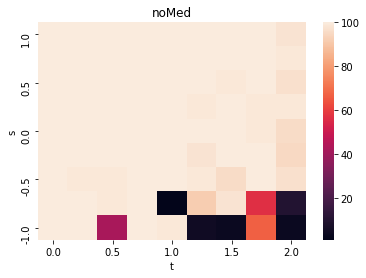

In [219]:
coopLandscape(ts, res, 'noMed')

81
t      0.00  0.25  0.50  0.75  1.00  1.25  1.50  1.75  2.00
s                                                          
 1.00   100   100   100   100   100   100   100   100    99
 0.75   100   100   100   100    98    98    99   100   100
 0.50   100   100    96    99    98   100   100    98    94
 0.25   100   100   100   100    99   100    99   100    97
 0.00   100   100   100   100    99    97    99    96    92
-0.25   100   100    99   100    99    97    97    98    97
-0.50   100   100   100    98    99   100    98    89    80
-0.75   100    98    98    99    93    98    83    85    92
-1.00   100    89    97    90    93    74    81    79    14


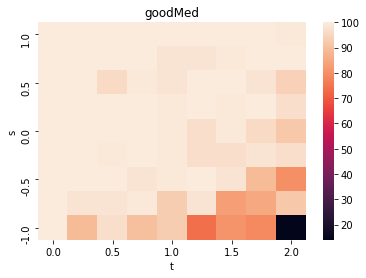

In [218]:
coopLandscape(ts_g, res_g, 'goodMed')

81
t      0.00  0.25  0.50  0.75  1.00  1.25  1.50  1.75  2.00
s                                                          
 1.00   100   100   100    97    87    89    88    78    49
 0.75    99    96    99    97    92    89    77    73    59
 0.50    99    98    98    95    94    69    77    61    53
 0.25   100   100    99    94    78    63    68    52    56
 0.00   100    99    93    82    58    60    46    35    17
-0.25    99    94    92    60    67    32    16    29     2
-0.50    96    93    50    61     3    27     3     0     1
-0.75    94    68     2     3     2     0     7     3     2
-1.00    42     0     1     0     1     2     2     0     0


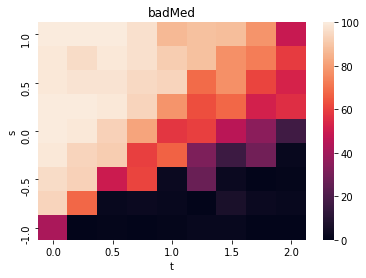

In [217]:
coopLandscape(ts_b, res_b, 'badMed')